  # Ejercicio 3.3.1. 
  Estimar con RNF la riqueza de especies de aves invernantes a partir de predictores ambientales, 
  
  a) Optimizar el nº de épocas con checkpoint_callback; 
  
  b) Inferir la riqueza de especies esperable en una nueva localidad (NvLoc). 

In [338]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, TensorBoard
import pickle
from datetime import datetime
import warnings
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error

np.random.seed(3)
import os 

warnings.filterwarnings('ignore')

In [85]:
os.chdir('/home/rsoriano/CursoML3/Numspc/')
Numspc = pd.read_csv('Numspc.csv')
display(Numspc.columns)
data = Numspc.copy()
display(data.head())

Index(['nspp', 'altmed', 'rangoalt', 'shannon', 'tempmin', 'precip'], dtype='object')

,nspp,altmed,rangoalt,shannon,tempmin,precip
0,46,310,399,0.93,5.2,128.1
1,36,713,39,1.42,1.6,156.4
2,46,606,1151,2.45,2.1,456.0
3,36,446,330,1.25,5.1,393.5
4,51,342,167,1.37,3.2,272.5


In [150]:
# dividir en train & test data
 # no se preselecciona valdata porque se hace con validation_split = 0.2 en history
 # hay que hacerlo cuando los datos están estructurados para que sean independientes 
 # de los de entrenamiento
X = data.drop(axis=1, columns = ['nspp'])
y = data[['nspp']]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=3)

In [151]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [152]:
# Antes se crea una función (no es imprescindible) para poder 
# renovar el modelo con facilidad en cada nueva prueba

def build_model():
    # Se crea un objeto "modelo secuencial" que alojará una pila lineal 
    # de capas en el orden que uno quiera
    model = Sequential()
    
    # Se crean 2 capas ocultas densas (totalmente conectadas porque son FFNN)  
    # con 64 neuronas cada una, cuya FdA es ReLU. 
    
    # En la 1ª se indican las dimensiones del tensor de entrada, dim(traindatax)
    # (799 muestras X 5 CCS), pero se excluye el nº de muestras (799)
    model.add(Dense(units=64, activation='relu', input_shape=(X_train.shape[1],)))

    model.add(Dense(units=64, activation='relu'))

    # Se crea una capa de salida que no tiene FdA porque es regresión
    # units = 1 porque esperamos un solo valor
    model.add(Dense(units=1))

    # Tipo de optimizador Adam y TdA (learning_rate)    
    optimizer = Adam(learning_rate=0.001)

    # La función compile() sirve para configurar el proceso de aprendizaje del modelo.
    # loss = "mse" => La FdP que el algoritmo trata de minimizar.
    # metrics = ["mae"] => una o más metricas para monitorizar el rendimiento 
    # Se obtiene la evolución de loss y metrics sobre las muestras de entrenamiento 
    # (loss y metric) y sobre las muestras de validación (val_loss y val_metrica)
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

    return model

In [153]:
model = build_model()  # se crea el modelo

In [154]:
# Para que guarde automáticamente el mejor modelo (save_best_only = True),
# de acuerdo con la métrica indicada en monitor, val_loss en este caso.
checkpoint = ModelCheckpoint(
    filepath='best_model_NSpc.h5',  # Ubicación donde guardar el modelo
    monitor='val_loss',  # Métrica para indentificar el mejor modelo. Puede ser también 'val_metrica'
    save_best_only=True,  # Guarda solo el modelo que tiene el menor valor de monitor
    verbose=1
)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Crear un directorio para los registros de TensorBoard
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [155]:
%%capture
history = model.fit(
    X_train,            # Conjunto de entrenamiento (features)
    y_train,            # Etiquetas del conjunto de entrenamiento
    epochs=300,         # Número de épocas (iteraciones completas sobre el conjunto de entrenamiento)
    batch_size=16,       # Tamaño del lote (número de ejemplos de entrenamiento utilizados en una iteración)
    validation_split=0.2, # Porcentaje de datos de entrenamiento a utilizar como conjunto de validación
    callbacks=[checkpoint, tensorboard_callback],# Lista de objetos de callback a aplicar durante el entrenamiento
    verbose = 0
);

## Plots

In [156]:
# Obtener las métricas de entrenamiento y validación
train_mse = history.history['loss']
val_mse = history.history['val_loss']

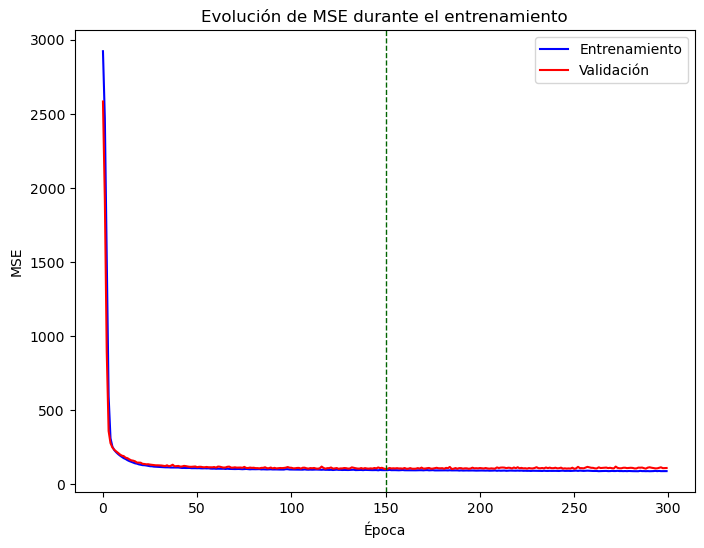

Época con menor MSE en validación: 150


In [157]:
plt.figure(figsize=(8, 6))
plt.plot(train_mse, label='Entrenamiento', color='blue')
plt.plot(val_mse, label='Validación', color='red')

# Encuentra el índice del valor mínimo en val_mse
min_epoch = np.argmin(val_mse) 
min_val_mse = val_mse[min_epoch]

# Añade una línea vertical en el punto de menor MSE
plt.axvline(x=min_epoch, color='darkgreen', linestyle='--', linewidth=1)

plt.xlabel('Época')
plt.ylabel('MSE')
plt.title('Evolución de MSE durante el entrenamiento')
plt.legend()
plt.show()

# Imprime el índice de la época con el menor MSE
print(f"Época con menor MSE en validación: {min_epoch}")

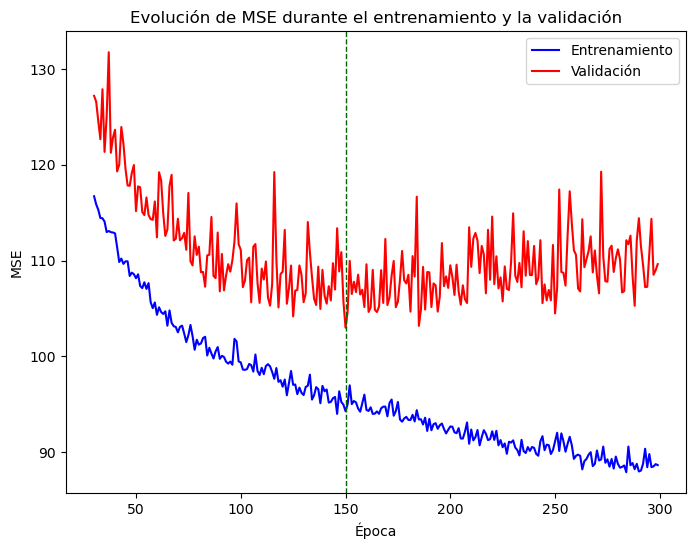

Época con menor MSE en validación: 150


In [158]:
n = 30  # Inicio del rango de épocas para el gráfico
epochs = len(train_mse)

# Gráfico de MSE
plt.figure(figsize=(8, 6))
plt.plot(range(n, epochs), train_mse[n:], label='Entrenamiento', color='blue')
plt.plot(range(n, epochs), val_mse[n:], label='Validación', color='red')

# Encuentra el índice del valor mínimo en val_mse
min_epoch = np.argmin(val_mse[n:]) + n
min_val_mse = val_mse[min_epoch - n]

# Añade una línea vertical en el punto de menor MSE
plt.axvline(x=min_epoch, color='darkgreen', linestyle='--', linewidth=1)

plt.xlabel('Época')
plt.ylabel('MSE')
plt.title('Evolución de MSE durante el entrenamiento y la validación')
plt.legend()
plt.show()

# Imprime el índice de la época con el menor MSE
print(f"Época con menor MSE en validación: {min_epoch}")


In [161]:
# Obtener las métricas de entrenamiento y validación
train_mae = history.history['mae']
val_mae = history.history['val_mae']

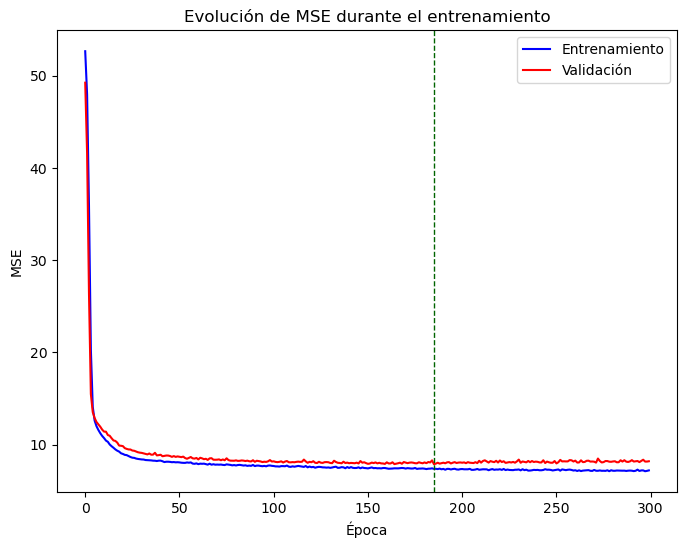

Época con menor MSE en validación: 185


In [162]:
plt.figure(figsize=(8, 6))
plt.plot(train_mae, label='Entrenamiento', color='blue')
plt.plot(val_mae, label='Validación', color='red')

# Encuentra el índice del valor mínimo en val_mse
min_epoch = np.argmin(val_mae) 
min_val_mae = val_mae[min_epoch]

# Añade una línea vertical en el punto de menor MSE
plt.axvline(x=min_epoch, color='darkgreen', linestyle='--', linewidth=1)

plt.xlabel('Época')
plt.ylabel('MSE')
plt.title('Evolución de MSE durante el entrenamiento')
plt.legend()
plt.show()

# Imprime el índice de la época con el menor MSE
print(f"Época con menor MSE en validación: {min_epoch}")

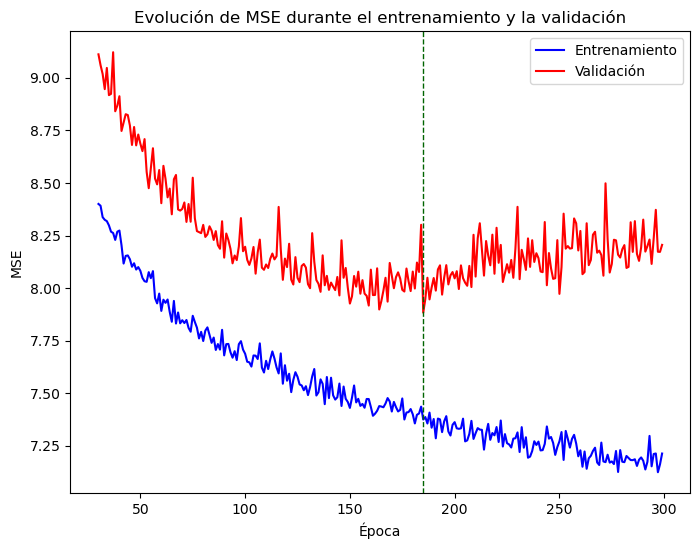

Época con menor MSE en validación: 185


In [163]:
n = 30  # Inicio del rango de épocas para el gráfico
epochs = len(train_mse)

# Gráfico de MSE
plt.figure(figsize=(8, 6))
plt.plot(range(n, epochs), train_mae[n:], label='Entrenamiento', color='blue')
plt.plot(range(n, epochs), val_mae[n:], label='Validación', color='red')

# Encuentra el índice del valor mínimo en val_mse
min_epoch = np.argmin(val_mae[n:]) + n
min_val_mae = val_mse[min_epoch - n]

# Añade una línea vertical en el punto de menor MSE
plt.axvline(x=min_epoch, color='darkgreen', linestyle='--', linewidth=1)

plt.xlabel('Época')
plt.ylabel('MSE')
plt.title('Evolución de MSE durante el entrenamiento y la validación')
plt.legend()
plt.show()

# Imprime el índice de la época con el menor MSE
print(f"Época con menor MSE en validación: {min_epoch}")

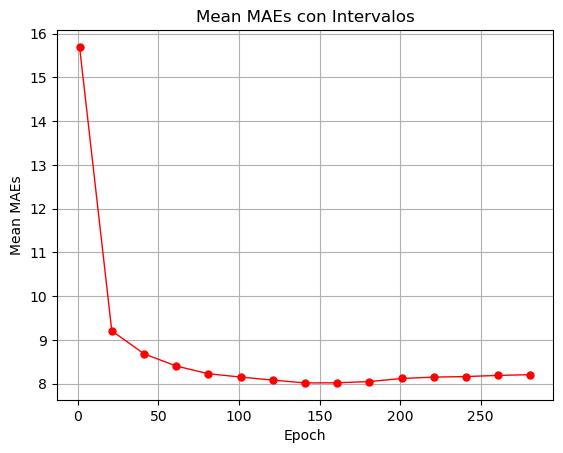

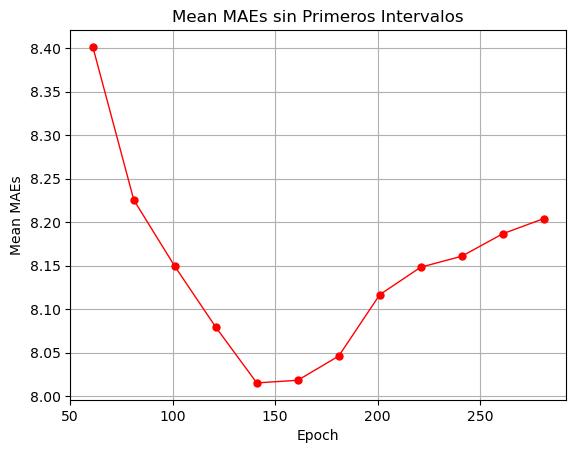

In [167]:
# Número de iteraciones por intervalo
ndiv = 20

# Dividir valmae en intervalos y calcular el promedio
segmae = [np.mean(val_mae[i*ndiv:(i+1)*ndiv]) for i in range((len(val_mae) + ndiv - 1) // ndiv)]
meanmaes = np.array(segmae)

# Crear vector de épocas correspondientes a los intervalos
epochs = len(val_mae)
epoch = np.arange(1, epochs + 1, ndiv)

# Gráfico de Mean MAEs
plt.figure()
plt.plot(epoch, meanmaes, 'bo-', markersize=5, color='red', linewidth=1)
plt.xlabel('Epoch')
plt.ylabel('Mean MAEs')
plt.title('Mean MAEs con Intervalos')
plt.grid(True)
plt.show()

# Si valores iniciales muy altos no dejan apreciar la curva
n = 3  # Número de intervalos que se dejan de representar (n X ndiv)
epoch_trimmed = np.arange((n*ndiv) + 1, epochs + 1, ndiv)

# Gráfico de Mean MAEs sin los primeros n intervalos
plt.figure()
plt.plot(epoch_trimmed, meanmaes[n:], 'bo-', markersize=5, color='red', linewidth=1)
plt.xlabel('Epoch')
plt.ylabel('Mean MAEs')
plt.title('Mean MAEs sin Primeros Intervalos')
plt.grid(True)
plt.show()


7/7 [==============================] - 0s 2ms/step
R^2: 0.26
RMSE: 11.05


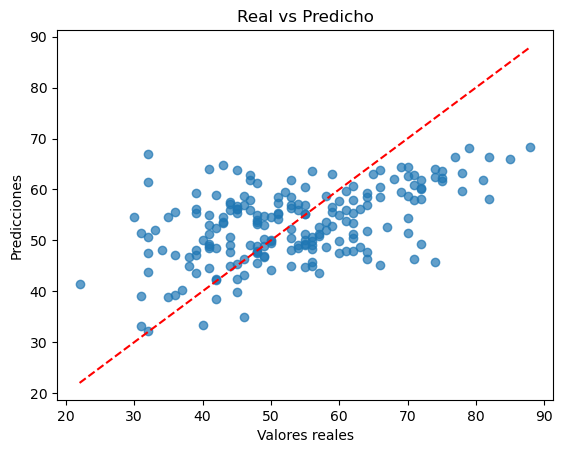

In [175]:
# Cargar el modelo con el mejor desempeño
best_model = load_model("best_model_NSpc.h5")

# Realizar las predicciones con el mejor modelo
preds = best_model.predict(scaler.transform(X_test))

# Convertir DataFrames a arrays NumPy y luego a arrays unidimensionales
y_test_array = np.array(y_test).flatten()

# Calcular R2
rsq = np.corrcoef(preds.flatten(), y_test_array)[0, 1]**2
print(f'R^2: {round(rsq, 2)}')

# Calcular RMSE
rmse = np.sqrt(np.mean((preds.flatten() - y_test_array)**2))
print(f'RMSE: {round(rmse, 2)}')

# Visualización de predicciones vs valores reales
plt.figure()
plt.scatter(y_test_array, preds.flatten(), alpha=0.7)
plt.plot([min(y_test_array), max(y_test_array)], [min(y_test_array), max(y_test_array)], color='red', linestyle='--')
plt.title('Real vs Predicho')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.show()

# Ejercicio 3.3.2

Ejercicio 3.3.2. SOLOS Estimar con RNF la masa corporal de las aves a partir de su morfología, 

a) Optimizar el nº de épocas checkpoint_callback; 

b) estimar la masa corporal de Accipiter brachyurus, Cincloramphus cruralis y Tigriornis leucolopha (datos reales pero no de una investigación real). 

In [279]:
os.chdir('/home/rsoriano/CursoML3/AVONETMsCrp/')
Aves = pd.read_csv('AVONET0.csv')
display(Aves.columns)
data = Aves.copy()
display(data.head())

Index(['Species', 'Family', 'Order', 'BkL', 'BNL', 'BkD', 'BkW', 'TsL', 'WnL',
       'SWL', 'KpD', 'TlL', 'HWI', 'Mass', 'Habitat', 'Hab.Dns', 'Migrt',
       'TrphL', 'Trph.Nch', 'Life.stl', 'MinLat', 'MaxLat', 'CntLat', 'CntLon',
       'RngSz'],
      dtype='object')

,Species,Family,Order,BkL,BNL,BkD,BkW,TsL,WnL,SWL,...,Hab.Dns,Migrt,TrphL,Trph.Nch,Life.stl,MinLat,MaxLat,CntLat,CntLon,RngSz
0,Gallicolumba rubescens,Columbidae,Columbiformes,17.2,9.9,3.8,2.9,28.8,120.6,88.2,...,1.0,1.0,Herbivore,Granivore,In,-9.44,-7.90,-8.14,-140.34,9.82
1,Sporophila hypochroma,Emberizidae,Passeriformes,9.2,5.8,5.3,4.6,12.3,53.0,40.6,...,3.0,2.0,Herbivore,Granivore,In,-33.78,-23.46,-28.65,-58.36,200480.73
2,Lanius mackinnoni,Laniidae,Passeriformes,20.2,11.6,8.6,7.2,25.1,85.0,70.0,...,3.0,1.0,Carnivore,Invertivore,In,-9.66,7.55,-0.64,22.18,1193617.21
3,Casiornis fuscus,Tyrannidae,Passeriformes,16.2,10.6,5.0,5.6,19.6,75.6,64.7,...,2.0,1.0,Carnivore,Invertivore,In,-15.81,-0.58,-7.54,-44.78,2107102.83
4,Luscinia calliope,Muscicapidae,Passeriformes,16.2,8.9,3.7,3.4,28.8,78.2,59.8,...,2.0,3.0,Carnivore,Invertivore,Tr,32.23,70.06,57.27,112.34,10841460.62


In [311]:
selected_species = ['Rhea americana', 'Rhea pennata', 'Aptenodytes patagonicus']
X_Nwspcs = data[data['Species'].isin(selected_species)].drop(columns=['Mass'])[["TsL","WnL","SWL","KpD","TlL","HWI"]]
y_Nwspcs = data[data['Species'].isin(selected_species)][['Mass']]

In [313]:
filtered_data = data[~data['Species'].isin(selected_species)]
X = filtered_data[["TsL","WnL","SWL","KpD","TlL","HWI"]]
y = filtered_data[['Mass']]

In [314]:
X_train, y_train, X_test, y_test = X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=3)

In [315]:
# Datos son muy heterogéneos pueden dificultar el aprendizaje.
# Normalizar es recomendable. Se puede utilizar la función scale()
# No estandariza, solo hace la media 0 y la desviación típica 1.
# Todo (train, test y newdata) se normaliza con la media y sd de traindata
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [316]:
model = build_model()  # se crea el modelo

In [317]:
# Para que guarde automáticamente el mejor modelo (save_best_only = True),
# de acuerdo con la métrica indicada en monitor, val_loss en este caso.
checkpoint = ModelCheckpoint(
    filepath='best_model_NSpc.h5',  # Ubicación donde guardar el modelo
    monitor='val_loss',  # Métrica para indentificar el mejor modelo. Puede ser también 'val_metrica'
    save_best_only=True,  # Guarda solo el modelo que tiene el menor valor de monitor
    verbose=1
)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Crear un directorio para los registros de TensorBoard
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [361]:
%%capture
history = model.fit(
    X_train,            # Conjunto de entrenamiento (features)
    y_train_encoded,            # Etiquetas del conjunto de entrenamiento
    epochs=1000,         # Número de épocas (iteraciones completas sobre el conjunto de entrenamiento)
    batch_size=16,       # Tamaño del lote (número de ejemplos de entrenamiento utilizados en una iteración)
    validation_split=0.2, # Porcentaje de datos de entrenamiento a utilizar como conjunto de validación
    callbacks=[checkpoint],# Lista de objetos de callback a aplicar durante el entrenamiento
    verbose = 0
);

In [362]:
# Obtener las métricas de entrenamiento y validación
train_mse = history.history['loss']
val_mse = history.history['val_loss']

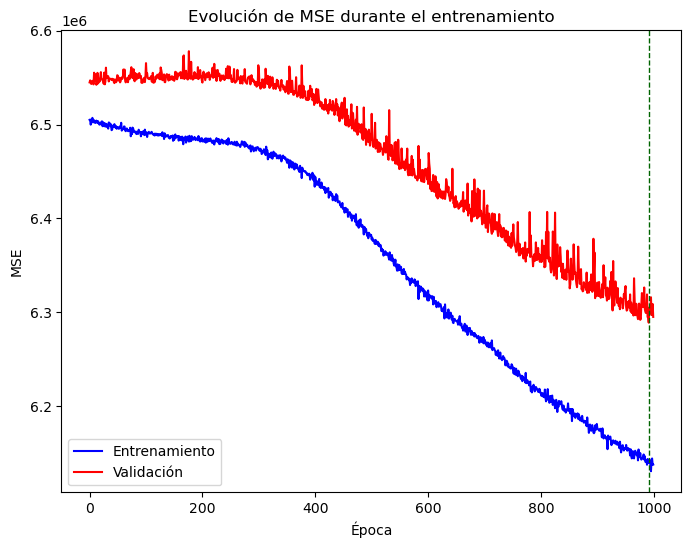

Época con menor MSE en validación: 991


In [363]:
plt.figure(figsize=(8, 6))
plt.plot(train_mse, label='Entrenamiento', color='blue')
plt.plot(val_mse, label='Validación', color='red')

# Encuentra el índice del valor mínimo en val_mse
min_epoch = np.argmin(val_mse) 
min_val_mse = val_mse[min_epoch]

# Añade una línea vertical en el punto de menor MSE
plt.axvline(x=min_epoch, color='darkgreen', linestyle='--', linewidth=1)

plt.xlabel('Época')
plt.ylabel('MSE')
plt.title('Evolución de MSE durante el entrenamiento')
plt.legend()
plt.show()

# Imprime el índice de la época con el menor MSE
print(f"Época con menor MSE en validación: {min_epoch}")

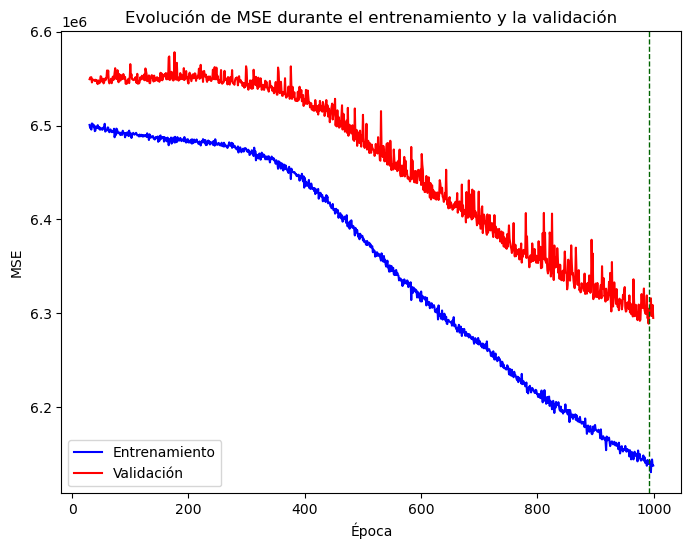

Época con menor MSE en validación: 991


In [364]:
n = 30  # Inicio del rango de épocas para el gráfico
epochs = len(train_mse)

# Gráfico de MSE
plt.figure(figsize=(8, 6))
plt.plot(range(n, epochs), train_mse[n:], label='Entrenamiento', color='blue')
plt.plot(range(n, epochs), val_mse[n:], label='Validación', color='red')

# Encuentra el índice del valor mínimo en val_mse
min_epoch = np.argmin(val_mse[n:]) + n
min_val_mse = val_mse[min_epoch - n]

# Añade una línea vertical en el punto de menor MSE
plt.axvline(x=min_epoch, color='darkgreen', linestyle='--', linewidth=1)

plt.xlabel('Época')
plt.ylabel('MSE')
plt.title('Evolución de MSE durante el entrenamiento y la validación')
plt.legend()
plt.show()

# Imprime el índice de la época con el menor MSE
print(f"Época con menor MSE en validación: {min_epoch}")


In [365]:
# Obtener las métricas de entrenamiento y validación
train_mae = history.history['mae']
val_mae = history.history['val_mae']

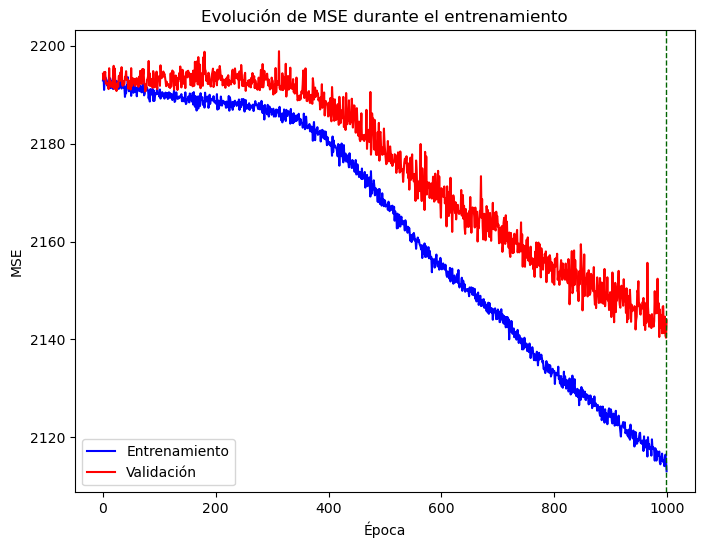

Época con menor MSE en validación: 998


In [366]:
plt.figure(figsize=(8, 6))
plt.plot(train_mae, label='Entrenamiento', color='blue')
plt.plot(val_mae, label='Validación', color='red')

# Encuentra el índice del valor mínimo en val_mse
min_epoch = np.argmin(val_mae) 
min_val_mae = val_mae[min_epoch]

# Añade una línea vertical en el punto de menor MSE
plt.axvline(x=min_epoch, color='darkgreen', linestyle='--', linewidth=1)

plt.xlabel('Época')
plt.ylabel('MSE')
plt.title('Evolución de MSE durante el entrenamiento')
plt.legend()
plt.show()

# Imprime el índice de la época con el menor MSE
print(f"Época con menor MSE en validación: {min_epoch}")

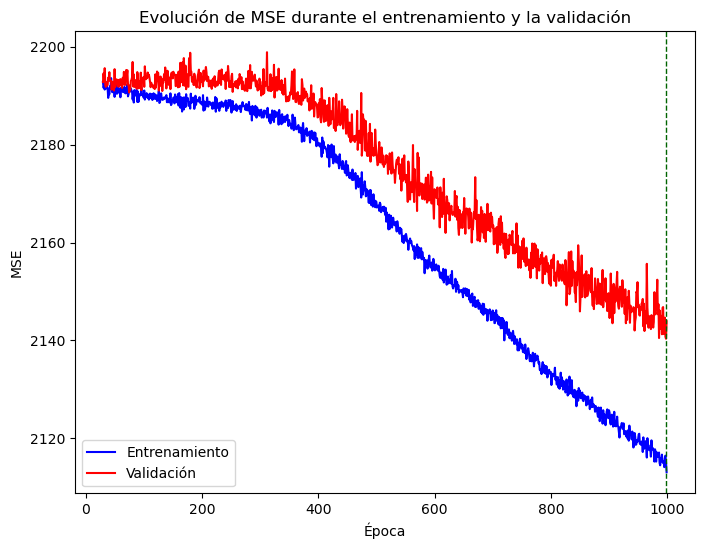

Época con menor MSE en validación: 998


In [367]:
n = 30  # Inicio del rango de épocas para el gráfico
epochs = len(train_mse)

# Gráfico de MSE
plt.figure(figsize=(8, 6))
plt.plot(range(n, epochs), train_mae[n:], label='Entrenamiento', color='blue')
plt.plot(range(n, epochs), val_mae[n:], label='Validación', color='red')

# Encuentra el índice del valor mínimo en val_mse
min_epoch = np.argmin(val_mae[n:]) + n
min_val_mae = val_mse[min_epoch - n]

# Añade una línea vertical en el punto de menor MSE
plt.axvline(x=min_epoch, color='darkgreen', linestyle='--', linewidth=1)

plt.xlabel('Época')
plt.ylabel('MSE')
plt.title('Evolución de MSE durante el entrenamiento y la validación')
plt.legend()
plt.show()

# Imprime el índice de la época con el menor MSE
print(f"Época con menor MSE en validación: {min_epoch}")

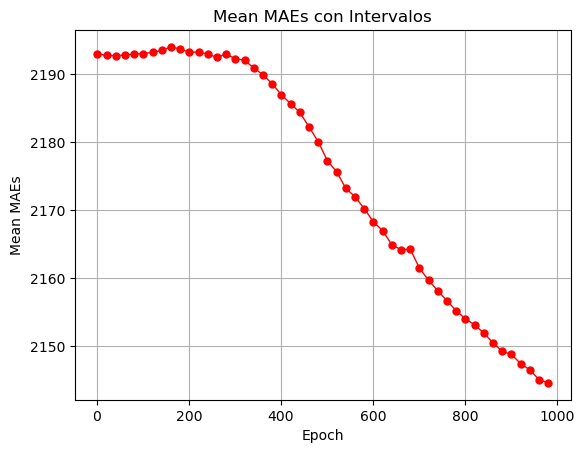

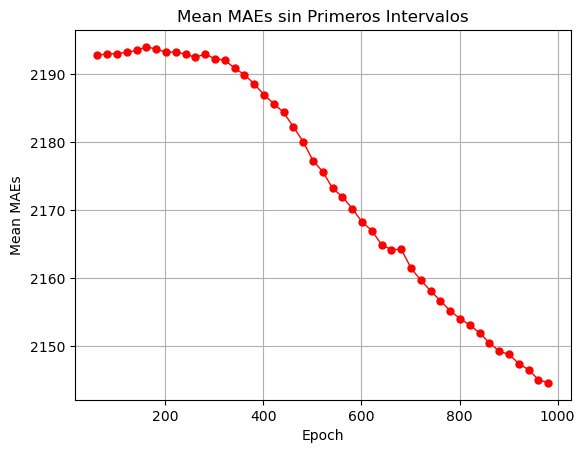

In [368]:
# Número de iteraciones por intervalo
ndiv = 20

# Dividir valmae en intervalos y calcular el promedio
segmae = [np.mean(val_mae[i*ndiv:(i+1)*ndiv]) for i in range((len(val_mae) + ndiv - 1) // ndiv)]
meanmaes = np.array(segmae)

# Crear vector de épocas correspondientes a los intervalos
epochs = len(val_mae)
epoch = np.arange(1, epochs + 1, ndiv)

# Gráfico de Mean MAEs
plt.figure()
plt.plot(epoch, meanmaes, 'bo-', markersize=5, color='red', linewidth=1)
plt.xlabel('Epoch')
plt.ylabel('Mean MAEs')
plt.title('Mean MAEs con Intervalos')
plt.grid(True)
plt.show()

# Si valores iniciales muy altos no dejan apreciar la curva
n = 3  # Número de intervalos que se dejan de representar (n X ndiv)
epoch_trimmed = np.arange((n*ndiv) + 1, epochs + 1, ndiv)

# Gráfico de Mean MAEs sin los primeros n intervalos
plt.figure()
plt.plot(epoch_trimmed, meanmaes[n:], 'bo-', markersize=5, color='red', linewidth=1)
plt.xlabel('Epoch')
plt.ylabel('Mean MAEs')
plt.title('Mean MAEs sin Primeros Intervalos')
plt.grid(True)
plt.show()


In [369]:
# Cargar el modelo con el mejor desempeño
best_model = load_model("best_model_NSpc.h5")

# Realizar las predicciones con el mejor modelo
preds = best_model.predict(X_test)

# # Convertir DataFrames a arrays NumPy y luego a arrays unidimensionales
y_test_array = np.array(y_test).flatten()

# # Calcular R2
r2 = r2_score(y_test_array, preds.flatten())
print(f'R^2: {round(r2, 2)}')

# # Calcular RMSE
rmse = np.sqrt(np.mean((preds.flatten() - y_test_array)**2))
print(f'RMSE: {round(rmse, 2)}')

# # Visualización de predicciones vs valores reales
# plt.figure()
# plt.scatter(y_test_array, preds.flatten(), alpha=0.7)
# plt.plot([min(y_test_array), max(y_test_array)], [min(y_test_array), max(y_test_array)], color='red', linestyle='--')
# plt.title('Real vs Predicho')
# plt.xlabel('Valores reales')
# plt.ylabel('Predicciones')
# plt.show()

32/32 [==============================] - 0s 982us/step
R^2: -39.75
RMSE: 4384.49


In [357]:
preds.flatten().shape

(8985,)

In [359]:
preds = best_model.predict(X_train)
y_train_array = np.array(y_train).flatten()
r2 = r2_score(y_train_array, preds.flatten())
print(f'R^2: {round(r2, 2)}')

281/281 [==============================] - 0s 873us/step
R^2: -35.11


In [360]:
preds

array([[4522.061 ],
       [4460.39  ],
       [4121.309 ],
       ...,
       [4833.925 ],
       [4733.0527],
       [4924.1406]], dtype=float32)